Example 1
=========

This notebook is available on github
[here](https://github.com/aezarebski/aas-extended-examples). If you find
errors or would like to suggest an improvement, feel free to create an
issue.

As usual we will start by importing some useful libraries.

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

Central limit theorem
---------------------

The central limit theorem (CLT) tells us about the limiting distribution
of the sample mean for distribution for an independent and identically
distributed (IID) sample with a finite variance. It underpins many
results in statistics and is important for reasoning about stochastic
processes.

### Question

Write down a statement of the law of large numbers (LLN). Write down a
statement of the central limit theorem. Make sure you understand what
each of them tells you.

**Central Limit Theorem**: As the sample size grows large, the sampling distribution of a random variable will approach a normal distribution

**Law of large numbers**: As the sample size grows, the mean of the sampling distribution approaches the population average

Example: CLT
------------

To see that the distribution of the sample mean converges to a normal
distribution we will do a simulation study.

### Question

Write down the distribution of the sample mean given an IID sample of
exponential random variables with rate $1/5$.

The mean of the distribution is $1/lambda$ which in our case is **5**

The variance of the distribution is also $1/lambda$ and thus also **5**

From the CLT we know that this approaches a normal distribution with parameters N(5, 25/n)

### Question

1.  Generate 500 sample means each based on a sample of 100 exponential
    random variables
2.  Make a visualisation of the distribution of the data (e.g., a KDE or
    histogram) and overlay the CLT approximation.

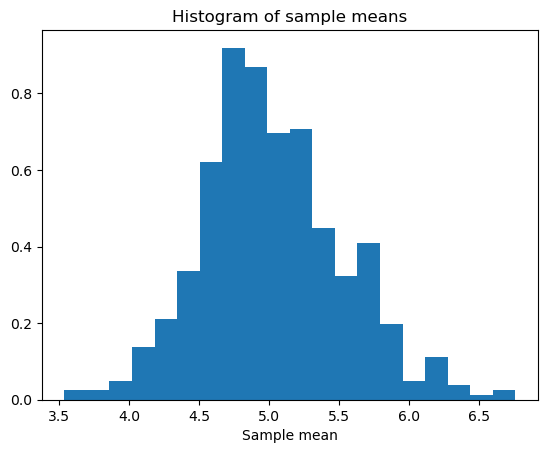

In [4]:
lambda_param = 0.2
sample_size = 100
n_samples = 500
sample_means = np.array([np.mean(stats.expon.rvs(scale=1/lambda_param, size=sample_size)) for i in range(n_samples)])

# Plot the histogram of the sample means
plt.hist(sample_means, bins=20, density=True)
plt.title('Histogram of sample means')
plt.xlabel('Sample mean')
plt.show()


Estimating the mean of a small sample
-------------------------------------

If we have a sample from a normal distribution with sample mean $\bar{x}$ and known the standard deviation, $\sigma$, the $(1-\alpha)100\%$ CI for the estimate of the mean is

$$
\bar{x} \pm z_{\alpha / 2} \frac{\sigma}{\sqrt{n}}
$$

### Question

Simulate a set of 5 draws from a $N(1,1)$ distribution and, assuming the standard deviation is known, check if the $95\%$ CI contains the true mean.

In [18]:
z_95 = stats.norm.ppf(0.975)
norm_draws = stats.norm.rvs(size=5, loc=1, scale=1)
conf_interval = z_95 * (1 / np.sqrt(5))
sample_mean = np.mean(norm_draws)
conf_min = sample_mean - conf_interval
conf_max = sample_mean + conf_interval
print(f"Confidence interval: ({conf_min}, {conf_max})")
print(f"Is the true mean in the confidence interval? {conf_min <= 1 <= conf_max}")

Confidence interval: (-1.0541372631382786, 0.6989078180148846)
Is the true mean in the confidence interval? False


### Question

Now repeat this process 1000 times and check how many times it contains the true mean. Do you think the coverage of the CI will be correct?

In [23]:
from typing import Tuple, Callable

def get_confidence_interval(sample_size=5, alpha=0.05, true_mean=1, true_sd=1) -> Tuple[float, float]:
    z_alpha = stats.norm.ppf(1 - alpha / 2)
    norm_draws = stats.norm.rvs(size=sample_size, loc=true_mean, scale=true_sd)
    conf_interval = z_alpha * (true_sd / np.sqrt(sample_size))
    sample_mean = np.mean(norm_draws)
    conf_min = sample_mean - conf_interval
    conf_max = sample_mean + conf_interval
    return conf_min, conf_max

def conf_contains_true(conf_function: Callable, true_mean=1) -> bool:
    conf_min, conf_max = conf_function()
    return conf_min <= true_mean <= conf_max

N = 1000
contains_true = [conf_contains_true(get_confidence_interval) for i in range(N)]

print(f"Proportion of confidence intervals that contain the true mean: {np.mean(contains_true)}")




Proportion of confidence intervals that contain the true mean: 0.951


### Question

Now repeat this 1000-fold repetition using the sample standard deviation instead of the true standard deviation but treat it as though it is known, ie continue with $z_{\alpha / 2}$. Do you think the coverage of the CI will be correct?

In [24]:

def get_confidence_interval_sample(sample_size=5, alpha=0.05, true_mean=1, true_sd=1) -> Tuple[float, float]:
    z_alpha = stats.norm.ppf(1 - alpha / 2)
    norm_draws = stats.norm.rvs(size=sample_size, loc=true_mean, scale=true_sd)
    conf_interval = z_alpha * (np.std(norm_draws) / np.sqrt(sample_size))
    sample_mean = np.mean(norm_draws)
    conf_min = sample_mean - conf_interval
    conf_max = sample_mean + conf_interval
    return conf_min, conf_max

N = 1000
contains_true = [conf_contains_true(get_confidence_interval_sample) for i in range(N)]
print(f"Proportion of confidence intervals that contain the true mean: {np.mean(contains_true)}")

Proportion of confidence intervals that contain the true mean: 0.844


### Question

Now repeat this process while accounting for the uncertainty in the standard deviation, ie use the $t_{\alpha / 2}$. How many degrees of freedom are there in the _t_-distribution? Do you think the coverage of the CI will be correct?

In [26]:
def conf_interval_t_dist(sample_size=5, alpha=0.05, true_mean=1, true_sd=1) -> Tuple[float, float]:
    t_alpha = stats.t.ppf(1 - alpha / 2, sample_size - 1)
    norm_draws = stats.norm.rvs(size=sample_size, loc=true_mean, scale=true_sd)
    conf_interval = t_alpha * (np.std(norm_draws) / np.sqrt(sample_size))
    sample_mean = np.mean(norm_draws)
    conf_min = sample_mean - conf_interval
    conf_max = sample_mean + conf_interval
    return conf_min, conf_max

N = 1000
contains_true = [conf_contains_true(conf_interval_t_dist) for i in range(N)]
print(f"Proportion of confidence intervals that contain the true mean: {np.mean(contains_true)}")

Proportion of confidence intervals that contain the true mean: 0.943


Testing the hypothesis that a coin is fair
------------------------------------------

There is an election to choose between candidate _A_ and candidate _B_. To win the election a candidate needs to get the majority of the votes. Candidate _B_ declared victory but there is suspicion that they cheated. A random sample of $n$ ballots had $m$ votes for _A_. We want to know if we can reject the null hypothesis that _B_ did in fact win.

### Question

Would we reject the null if $n=100$ and $m=70$? 

In [3]:
n = 100
num_success = 70

# Calculate the probability of getting 70 or more successes if the true probability of success is less than 0.5
p = 0.5
binom = stats.binom(n, p)
prob = 1 - binom.cdf(num_success)
print(f"Probability of getting 70 or more successes if the true probability of success is less than 0.5: {prob:.3f}")


Probability of getting 70 or more successes if the true probability of success is less than 0.5: 0.000


### Question

If $n=100$, how small would $m$ need to be for us to not be able to reject the null using this test?

In [8]:
n = 100
null_p = 0.5
binom = stats.binom(n, null_p)
# find the minimum number of successes required to reject the null hypothesis
min_success = binom.ppf(0.95)
print(f"Minimum number of successes required to reject the null hypothesis: {min_success:.0f}")

new_prob = 1 - binom.cdf(min_success)
print(f"Probability of getting 58 or more successes if the true probability of success is less than 0.5: {new_prob:.3f}")

Minimum number of successes required to reject the null hypothesis: 58
Probability of getting 58 or more successes if the true probability of success is less than 0.5: 0.044


Parameter estimation of the binomial distribution
-------------------------------------------------

We want to make an *estimate* the probability that a coin comes up
heads. We also want to understand the level of confidence we have in
this estimate; we use a *confidence interval* (CI) to describe the range
of values we are confident the \"true\" probability of heads lies
within.

Binomial random variables can be used to model the number of times a
coin comes up heads when flipped $n$ times. Let $X$ be a binomial random
variable (RV) representing the number of heads that are observed when a
coin is flipped $n$ times and the probability of coming up heads is $p$.
We assume that $n$ is known but $p$ is unknown.

The expected value of $X$, ie the average number of times that the coin
comes up heads, is $np$. So a simple way to estimate $p$ is to divide
the number of heads, $X$, by the number of flips, $n$. This gives the
estimate

$$
\hat{p} = X / n.
$$

This estimator is called the [the method of
moments](https://en.wikipedia.org/wiki/Method_of_moments_(statistics)). This is
also an example of a maximum likelihood estimate (MLE).

Given an estimator, such as $\hat{p}$, we usually want to quantify the
uncertainty. One way to construct a CI is to approximate the sampling
distribution by a normal distribution. It is a bit crude, but it is acceptable
when we have lots of data. The estimated standard error of $\hat{p}$ is
$\sqrt{\hat{p}(1-\hat{p})/n}$, so the CI is given by

$$
\hat{p} \pm z \sqrt{\frac{\hat{p}(1-\hat{p})}{n}}
$$

where $z$ is the appropriate quantile of the standard normal distribution. In
the case of a $95\%$ distribution this value is $1.96$.

### Question

State the limitations on the estimator we are using for the CI.

We are assuming that the sample variance is a good estimate for the true variance by more or less drop-in replacing the values. Given the LLN and CLT this is a decent assumption when n is large. However, for smaller n it would it might be better to conservatively use the t-score instead of the z-score to account for the introduced uncertainty

### Question

Implement a function called `estimate_and_ci` which takes two
arguments: `num_trials` which is $n$ in the description above, and
`num_success` which is $X$ above. The function should return
`(p_hat,(ci_lower,ci_upper))` where `p_hat` is $\hat{p}$ and
`ci_x` are the limits of the $95\%$ CI.

In [39]:
def estimate_and_ci(num_trials: int, nums_success: np.ndarray) -> Tuple[float, Tuple[float, float]]:
    """Estimate the probability of success and calculate a 95% confidence interval for the probability of success.
    
    Args:
        num_trials: The number of trials in the experiment
        nums_success: The number of successes in each trial
        
    Returns:
        A tuple containing the estimated probability of success and a tuple containing the lower and upper bounds of the
        95% confidence interval for the probability of success
    """
    p_hat = np.mean(nums_success / num_trials)
    se = np.sqrt(p_hat * (1 - p_hat) / num_trials)
    z_95 = stats.norm.ppf(0.975)
    conf_interval = z_95 * se
    conf_min = p_hat - conf_interval
    conf_max = p_hat + conf_interval
    return p_hat, (conf_min, conf_max)
    

### Question

Simulate a binomial random variable with $n=100$ and $p=0.6$. Then use
the value and the `estimate_and_ci` function to see how well you
can estimate $p$. Write a couple of sentences to explain this.

Recall that in a previous example we have looked at how to simulate
random variables using `scipy.stats`.

In [45]:
n = 100
p = 0.6
binom_sample = stats.binom.rvs(n, p, size=1)
p_hat, conf_interval = estimate_and_ci(n, binom_sample)
print(f"Estimated probability of success: {p_hat:.3f}")
print(f"95% confidence interval for the probability of success: {conf_interval}")

Estimated probability of success: 0.630
95% confidence interval for the probability of success: (0.5353720944380675, 0.7246279055619325)


### Question

Repeat the process from the previous question 100000 times and see what
proportion of the CIs capture the true value of $p$. Is it what you
expect? Write a couple of sentences to explain what you found.

In [ ]:
repetitions = 100_000
n = 100
p = 0.6
binom_sample = stats.binom.rvs(n, p, size=repetitions)
